#### Optimización de función de temperatura con Algoritmos Genéticos

In [233]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from deap import base, creator, tools, algorithms

#### Definición de los parámetros, funciones y configuración del GA

In [234]:
# --- 1. Definición del Problema ---
# INPUT: (hora (formato 24 hs), temperatura de la sup. terrestre en grados Celsius)
points = [(1, 11), (10, 12), (13, 34), (22, 28)] # Datos tomados de 2 satélites diferentes

# Límites para los coeficientes del polinomio
#BOUND_LOW, BOUND_UP = -20.0, 50.0 # Elegimos estos límites para que tenga cierta flexibilidad para buscar pero a la vez que no sea un espacio demasiado grande
BOUND_LOW, BOUND_UP = -10.0, 30
N_VARIABLES = 4  # 4 coeficientes (a, b, c, d) porque estamos usando un polinomio cúbico

# Defino mi función fitness
def evalPolynomial(individual, points):
    """
    Evalúa el error de un polinomio cúbico.
    Individuo: [a, b, c, d] coeficientes del polinomio
    """
    a, b, c, d = individual
    
    # Calcular error (suma de cuadrados)
    error = 0.0
    for x, y in points:
        y_pred = a*x**3 + b*x**2 + c*x + d
        error += (y - y_pred)**2
    
    return (error,)

In [ ]:
# --- 2. Configuración de DEAP (para individuos decimales)---
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Weights -1 porque queremos minimizar la función fitness
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Atributo generador de los individuos: valores float en el rango [BOUND_LOW, BOUND_UP]
for i in range(N_VARIABLES):
    toolbox.register(f"attr_float_{i}", random.uniform, BOUND_LOW, BOUND_UP)

# Crear individuos: lista de 4 floats [a, b, c, d]
toolbox.register("individual", tools.initCycle, creator.Individual,
                [toolbox.attr_float_0, toolbox.attr_float_1, 
                 toolbox.attr_float_2, toolbox.attr_float_3], n=1)
# Crear la población (lista de individuos)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# def checkBounds(individual):
#     """Asegura que los valores estén dentro de los límites."""
#     for i in range(len(individual)):
#         individual[i] = max(BOUND_LOW, min(BOUND_UP, individual[i]))
#     return individual

# Definimos los operadores genéticos
toolbox.register("evaluate", evalPolynomial, points=points) # Registro mi función fitness
toolbox.register("mate", tools.cxBlend, alpha=0.5) # Defino el mecanismo de cruza: Blend crossover 
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=3, indpb=0.2) # Mutación gaussiana
toolbox.register("select", tools.selTournament, tournsize=3) # Elegimos selección por torneo


/Users/ari/opt/miniconda3/envs/ae-env/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/ari/opt/miniconda3/envs/ae-env/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [236]:
# --- 3. Creamos una función para ejecutar el GA ---
def run_ga(pop_size=100, cruceprob=0.7, mutacionprob=0.2, 
           ngen=500, seed=42, verbose=True):
    """Ejecutar el algoritmo genético con los parámetros de entrada."""
    random.seed(seed)
    np.random.seed(seed)
    
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1) # Guardo solo el mejor progenitor de todos
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=cruceprob, mutpb=mutacionprob, 
                                       ngen=ngen, stats=stats, 
                                       halloffame=hof, verbose=verbose)
    
    return pop, logbook, hof

---
#### Ejecución única del Algoritmo Genético con los siguientes hiperparámetros:
- Población: 200 individuos
- Generaciones: 500
- cruceprob=0.7, 
- mutacionprob=0.2

In [237]:
# --- 4. Ejecución del Algoritmo Genético (única) ---
print("=== Ejecución única del GA ===\n")
pop, logbook, hof = run_ga(pop_size=200, ngen=500, seed=42)

best_ind = hof[0] # Tomo el primer elemento de la lista del hall de la fama que es el mejor
a, b, c, d = best_ind # Separo cada coeficiente

print("\n--- Resultados ---")
print(f"Mejor individuo:")
print(f"  a = {a:.10f}")
print(f"  b = {b:.10f}")
print(f"  c = {c:.10f}")
print(f"  d = {d:.10f}")
print(f"Fitness (error): {best_ind.fitness.values[0]:.10f}")

# Verificación (comparo los valores reales con los calculados con el polinomio)
print("\nVerificación de paso por los puntos (datos de Temperatura) que tenía como entrada:")
for x, y in points:
    y_pred = a*x**3 + b*x**2 + c*x + d
    error = (y - y_pred)**2
    print(f"  x={x}, y_real={y}, y_pred={y_pred:.4f}, error={error:.6e}")



=== Ejecución única del GA ===

gen	nevals	min       	avg        
0  	200   	4.1142e+06	3.03555e+10
1  	146   	284988    	7.36777e+09
2  	160   	27183.3   	1.38165e+09
3  	147   	27183.3   	3.16745e+08
4  	145   	27183.3   	1.14084e+08
5  	160   	15851.7   	4.36243e+07
6  	161   	51991.9   	3.94257e+07
7  	151   	1631.69   	7.30398e+07
8  	164   	1631.69   	3.14561e+07
9  	162   	801.985   	7.27823e+07
10 	153   	7106.9    	4.456e+07  
11 	156   	6815.58   	1.098e+08  
12 	148   	347.191   	5.08078e+07
13 	159   	2783.65   	4.92652e+07
14 	162   	2248.97   	8.82694e+07
15 	162   	2248.97   	6.02033e+07
16 	138   	2248.97   	7.99035e+07
17 	156   	2208.18   	5.53195e+07
18 	159   	2156.43   	9.20209e+06
19 	158   	2149.21   	1.14046e+08
20 	151   	293.074   	2.32373e+07
21 	149   	293.074   	8.51342e+07
22 	161   	1416.1    	2.54379e+07
23 	138   	1306.22   	1.83798e+07
24 	158   	1112.09   	7.05336e+07
25 	153   	1221.59   	5.98782e+07
26 	154   	816.832   	9.18931e+06
27 	157   	816.8

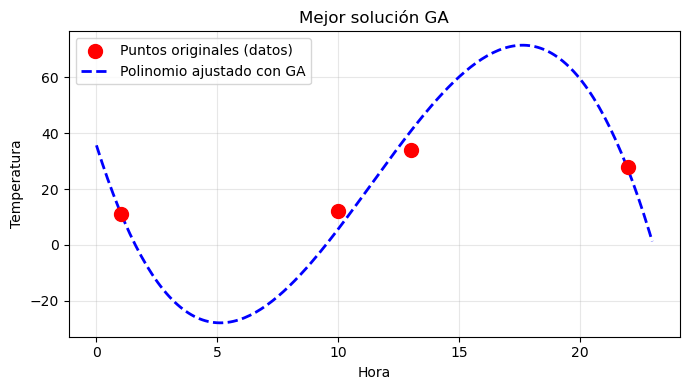

In [238]:
# --- 5. Visualización ---

# Creamos una función para graficar la curva ajustada y los datos originales
def plot_solucion(coef, points, title="Mejor solución GA"):
    """Grafica la solución encontrada."""
    a, b, c, d = coef
    xs = np.linspace(min(x for x, _ in points) - 1, 
                     max(x for x, _ in points) + 1, 200)
    ys = a * xs**3 + b * xs**2 + c * xs + d
    
    plt.figure(figsize=(7, 4))
    plt.scatter(*zip(*points), color='red', label='Puntos originales (datos)', s=100, zorder=3)
    plt.plot(xs, ys, color='blue', linestyle='--', label='Polinomio ajustado con GA', linewidth=2)
    plt.legend()
    plt.xlabel("Hora")
    plt.ylabel("Temperatura")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Ejecuto la función 
# best_ind son los coeficientes del mejor individuo
# points son los datos originales
plot_solucion(best_ind, points)

#### Curva de convergencia del GA para la ejecución única

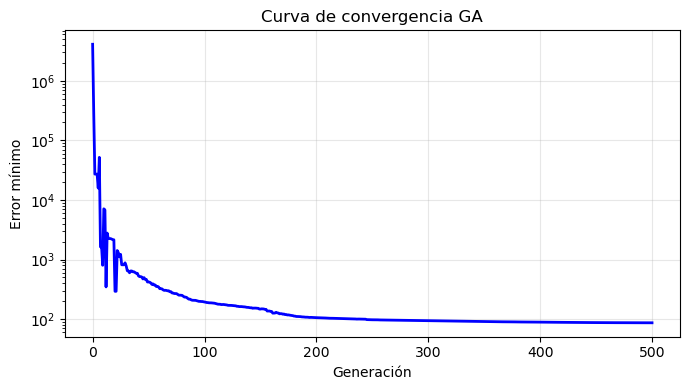

In [239]:
# Curva de convergencia
gen = logbook.select("gen")
fit_mins = logbook.select("min")

plt.figure(figsize=(7, 4))
plt.plot(gen, fit_mins, color='blue', linewidth=2)
plt.xlabel("Generación")
plt.ylabel("Error mínimo")
plt.title("Curva de convergencia GA")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Observación sobre esta ejecución: el algoritmo converge rápidamente, pero no logra un error muy bajo. Posiblemente se deba a que la población es pequeña y no hay suficiente diversidad genética.

---
#### Ejecuciones múltiples del GA

In [240]:
# --- 6. Evaluación con múltiples trials ---

# Creo una función que me permite calcular múltiples ensayos del mismo GA (30 veces por defecto)
def run_multiple_trials(num_trials=30, pop_size=200, ngen=500, cruceprob=0.7, mutacionprob=0.2,
                       base_seed=42, titulo='Base'):
    """Ejecuta múltiples trials del GA."""
    print(f"\n{'='*60}")
    print(f"Prueba '{titulo}' - {num_trials} trials")
    print(f"{'='*60}")
    
    final_errors = []
    convergence_curves = []
    best_overall = None
    min_error = float('inf')
    
    for trial in range(num_trials):
        seed = base_seed + trial
        pop, logbook, hof = run_ga(pop_size=pop_size, 
                                   ngen=ngen, seed=seed, cruceprob=cruceprob, mutacionprob=mutacionprob, verbose=False)
        
        best_ind = hof[0]
        error = best_ind.fitness.values[0]
        final_errors.append(error)
        
        fit_mins = logbook.select("min")
        convergence_curves.append(fit_mins)
        
        print(f"  Trial {trial+1:2d} (seed={seed:3d}): Error = {error:.6e}")
        
        if error < min_error:
            min_error = error
            best_overall = list(best_ind)
    
    return final_errors, convergence_curves, best_overall


---
#### Pruebas de consistencia y estabilidad

Analizamos 5 variantes del GA (A, B, C, D y E) con diferentes hiperparámetros (se varía el tamaño de población, nro de generaciones, probabilidad de cruza y de mutación) y comparamos sus resultados. Cada variante se ejecuta 30 veces.

In [241]:
# --- 7. Configuraciones de Algoritmos ---
print("\n" + "="*90)
print("EVALUACIÓN DE HIPERPARÁMETROS")
print("="*90)

# Algoritmo A: 
errors_A, curves_A, coef_A = run_multiple_trials(
    num_trials=30, pop_size=150, ngen=400, cruceprob=0.7, mutacionprob=0.2, titulo='Algoritmo_A')

# Algoritmo B: 
errors_B, curves_B, coef_B = run_multiple_trials(
    num_trials=30, pop_size=800, ngen=600, cruceprob=0.8, mutacionprob=0.2, titulo='Algoritmo_B')


# Algoritmo C: 
errors_C, curves_C, coef_C = run_multiple_trials(
    num_trials=30, pop_size=1500, ngen=1000, cruceprob=0.8, mutacionprob=0.2, titulo='Algoritmo_C')

# Algoritmo D: 
errors_D, curves_D, coef_D = run_multiple_trials(
    num_trials=30, pop_size=1500, ngen=1000, cruceprob=0.9, mutacionprob=0.2, titulo='Algoritmo_D')

# Algoritmo E: 
errors_E, curves_E, coef_E = run_multiple_trials(
    num_trials=30, pop_size=1500, ngen=1000, cruceprob=0.8, mutacionprob=0.1, titulo='Algoritmo_E')


EVALUACIÓN DE HIPERPARÁMETROS

Prueba 'Algoritmo_A' - 30 trials
  Trial  1 (seed= 42): Error = 2.602590e+02
  Trial  2 (seed= 43): Error = 1.860610e+03
  Trial  3 (seed= 44): Error = 7.132818e+02
  Trial  4 (seed= 45): Error = 2.791698e+02
  Trial  5 (seed= 46): Error = 8.271717e+02
  Trial  6 (seed= 47): Error = 6.852788e+01
  Trial  7 (seed= 48): Error = 2.177325e+01
  Trial  8 (seed= 49): Error = 3.323457e+02
  Trial  9 (seed= 50): Error = 9.812078e+01
  Trial 10 (seed= 51): Error = 6.694999e+01
  Trial 11 (seed= 52): Error = 2.062948e+02
  Trial 12 (seed= 53): Error = 8.470495e+00
  Trial 13 (seed= 54): Error = 3.582768e+00
  Trial 14 (seed= 55): Error = 1.188444e+03
  Trial 15 (seed= 56): Error = 7.143316e+01
  Trial 16 (seed= 57): Error = 1.693878e+02
  Trial 17 (seed= 58): Error = 8.133493e+00
  Trial 18 (seed= 59): Error = 7.092691e+02
  Trial 19 (seed= 60): Error = 9.181463e+02
  Trial 20 (seed= 61): Error = 8.344508e+01
  Trial 21 (seed= 62): Error = 5.605225e+02
  Trial 22 

#### Tabla comparativa de resultados de las 5 variantes de GA

In [242]:
# --- 8. Armamos una tabla comparativa ---
data = {
    'Algoritmo': ['Algoritmo_A', 'Algoritmo_B', 'Algoritmo_C', 'Algoritmo_D', 'Algoritmo_E'],
    'Mínimo': [np.min(errors_A), np.min(errors_B), np.min(errors_C), np.min(errors_D), np.min(errors_E)],
    'Promedio': [np.mean(errors_A), np.mean(errors_B), np.mean(errors_C), np.mean(errors_D), np.mean(errors_E)],
    'Máximo': [np.max(errors_A), np.max(errors_B), np.max(errors_C), np.max(errors_D), np.max(errors_E)],
    'Desviación estándar': [np.std(errors_A), np.std(errors_B), np.std(errors_C), np.std(errors_D), np.std(errors_E)]
}
df = pd.DataFrame(data)
print("\n" + "="*60)
print("TABLA COMPARATIVA DE RESULTADOS")
print("="*60)
# print(df.to_string(index=False))
df.head()



TABLA COMPARATIVA DE RESULTADOS


,Algoritmo,Mínimo,Promedio,Máximo,Desviación estándar
0,Algoritmo_A,3.582768,367.606391,1860.610262,445.995330
1,Algoritmo_B,1.578540,83.861923,314.116162,87.886223
2,Algoritmo_C,0.000718,52.344615,181.137369,43.219054
3,Algoritmo_D,0.021472,71.074768,430.410370,92.696571
4,Algoritmo_E,0.023757,42.624124,270.758365,61.871801


#### Boxplots para comparar la distribución de los resultados para las 5 variantes

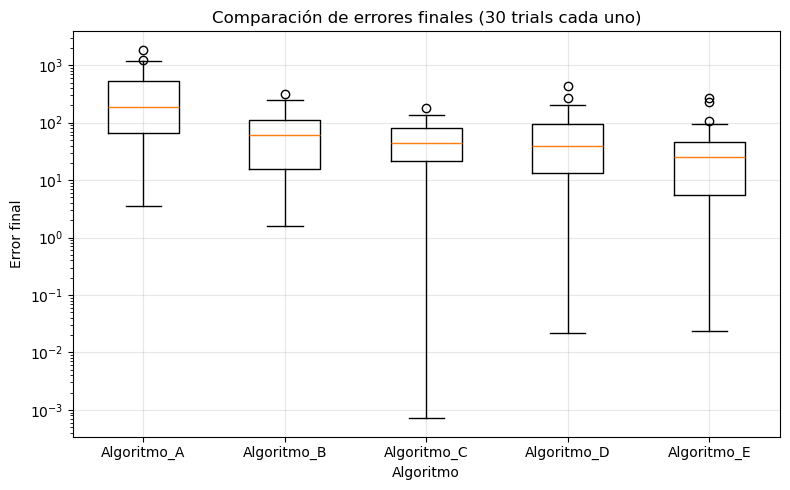

In [243]:
# --- 9. Boxplots ---
plt.figure(figsize=(8, 5))
plt.boxplot([errors_A, errors_B, errors_C, errors_D, errors_E], 
            tick_labels=['Algoritmo_A', 'Algoritmo_B', 'Algoritmo_C', 'Algoritmo_D', 'Algoritmo_E'])
plt.xlabel("Algoritmo")
plt.ylabel("Error final")
plt.title("Comparación de errores finales (30 trials cada uno)")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Gráficos de convergencia promedio para cada variante

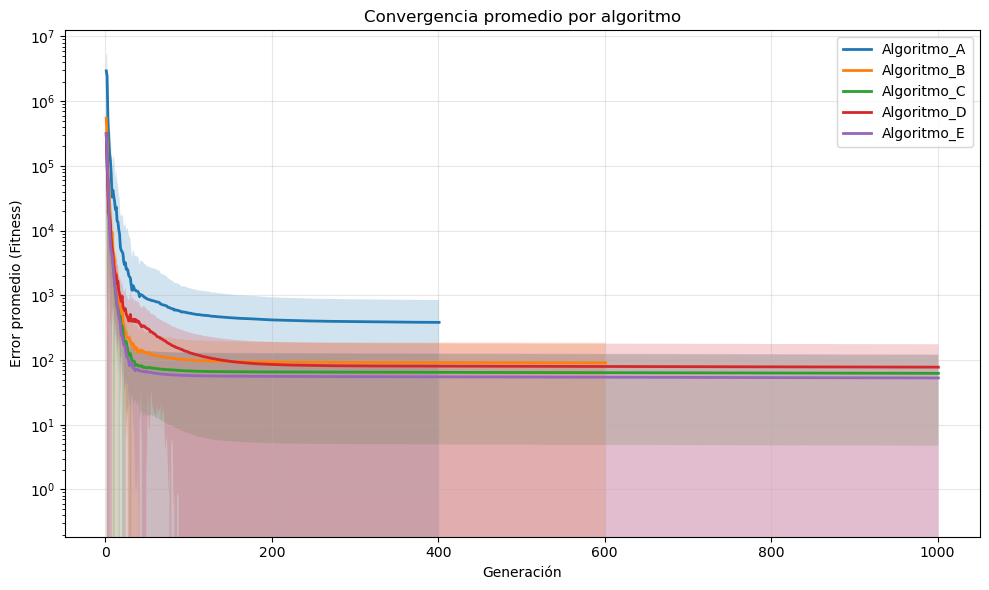

In [244]:
# --- 10. Convergencia promedio ---

# Armamos una función para graficar la convergencia promedio
def plot_average_convergence(curves_list, label):
    """Grafica la convergencia promedio con banda de desviación estándar."""
    max_len = max(len(c) for c in curves_list)
    padded_curves = [c + [c[-1]] * (max_len - len(c)) for c in curves_list]
    avg_curve = np.mean(padded_curves, axis=0)
    std_curve = np.std(padded_curves, axis=0)
    gens = np.arange(1, max_len + 1)
    plt.plot(gens, avg_curve, label=label, linewidth=2)
    plt.fill_between(gens, avg_curve - std_curve, avg_curve + std_curve, alpha=0.2)

plt.figure(figsize=(10, 6))
plot_average_convergence(curves_A, 'Algoritmo_A')
plot_average_convergence(curves_B, 'Algoritmo_B')
plot_average_convergence(curves_C, 'Algoritmo_C')
plot_average_convergence(curves_D, 'Algoritmo_D')
plot_average_convergence(curves_E, 'Algoritmo_E')
plt.xlabel("Generación")
plt.ylabel("Error promedio (Fitness)")
plt.title("Convergencia promedio por algoritmo")
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Mejor solución encontrada


MEJOR SOLUCIÓN GENERAL
Mejor algoritmo: Algoritmo_C
Error mínimo: 7.176293e-04
Coeficientes: a=-0.060524, b=2.055670, c=-15.785705, d=24.794230


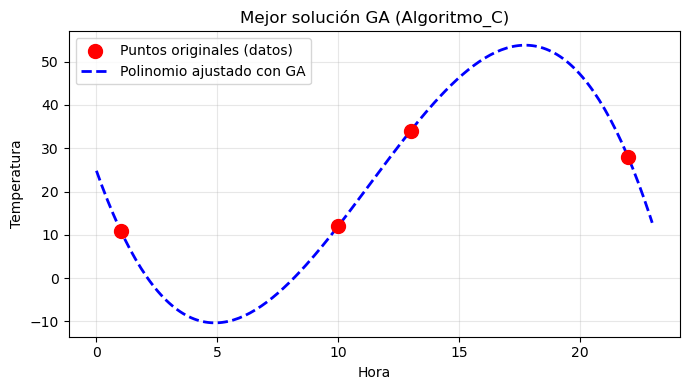

In [245]:
# --- 11. Mejor solución general ---
print("\n" + "="*60)
print("MEJOR SOLUCIÓN GENERAL")
print("="*60)

# Determinar cuál algoritmo tuvo el mejor resultado
best_errors = [np.min(errors_A), np.min(errors_B), np.min(errors_C), np.min(errors_D), np.min(errors_E)]
best_algo_idx = np.argmin(best_errors)
best_algo_names = ['Algoritmo_A', 'Algoritmo_B', 'Algoritmo_C', 'Algoritmo_D', 'Algoritmo_E']
best_coefs = [coef_A, coef_B, coef_C, coef_D, coef_E]

print(f"Mejor algoritmo: {best_algo_names[best_algo_idx]}")
print(f"Error mínimo: {best_errors[best_algo_idx]:.6e}")

a, b, c, d = best_coefs[best_algo_idx]
print(f"Coeficientes: a={a:.6f}, b={b:.6f}, c={c:.6f}, d={d:.6f}")
plot_solucion(best_coefs[best_algo_idx], points, 
              f"Mejor solución GA ({best_algo_names[best_algo_idx]})")


#### Validación del mejor algoritmo encontrado con datos de prueba

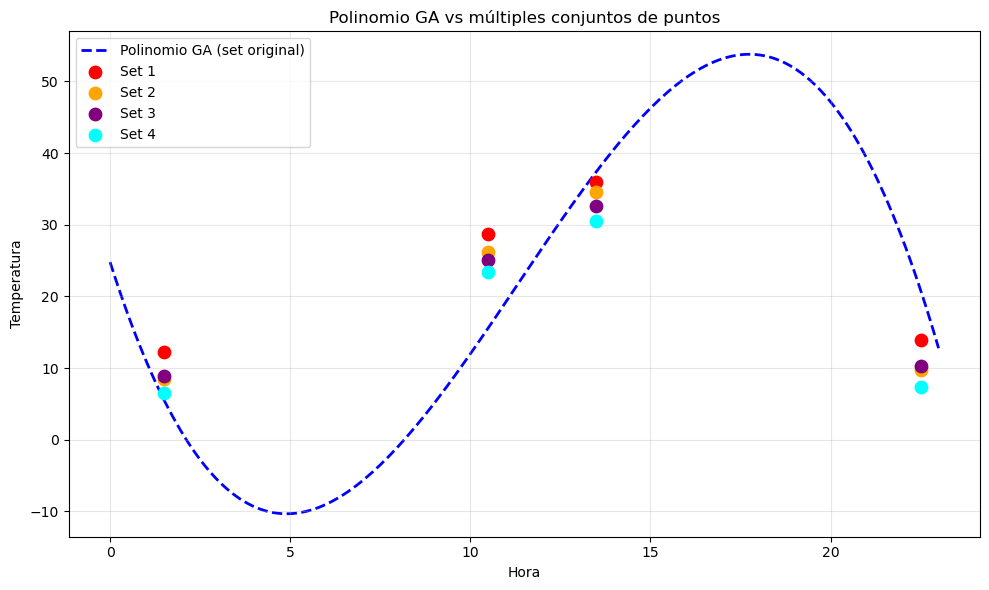


ERRORES POR CONJUNTO DE PUNTOS
  Set  Error Total      Punto 1      Punto 2      Punto 3      Punto 4
Set 1 2.655007e+02 4.466699e+01 1.703461e+02 2.080432e+00 4.840720e+01
Set 2 2.511720e+02 8.313633e+00 1.121835e+02 7.741585e+00 1.229333e+02
Set 3 2.349342e+02 1.091204e+01 9.028174e+01 2.249008e+01 1.112504e+02
Set 4 2.915592e+02 9.867186e-01 6.102219e+01 4.736702e+01 1.821833e+02


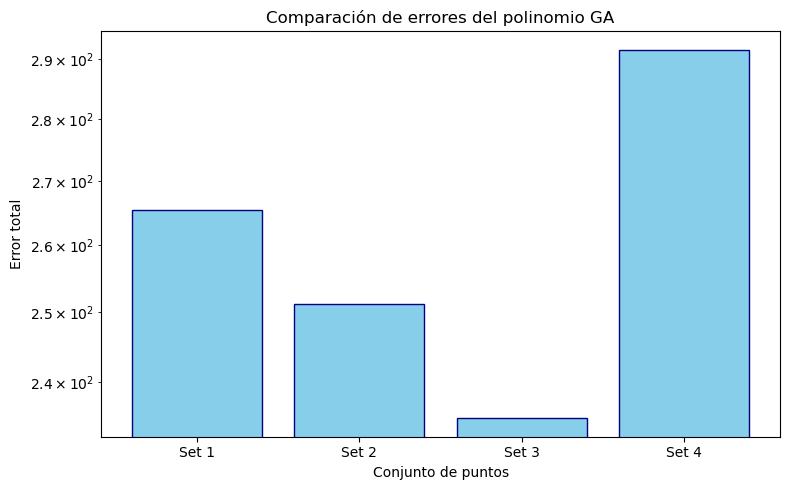

In [246]:
# --- 12. Validación con otros conjuntos de puntos ---
point_sets = [[(1.5, 12.22), (10.5, 28.67), (13.5, 35.98), (22.5, 13.94)],
 [(1.5, 8.42), (10.5, 26.21), (13.5, 34.64), (22.5, 9.81)],
 [(1.5, 8.84), (10.5, 25.12), (13.5, 32.68), (22.5, 10.35)],
 [(1.5, 6.53), (10.5, 23.43), (13.5, 30.54), (22.5, 7.4)]]

xs = np.linspace(0, 23, 200)
ys_ga = a * xs**3 + b * xs**2 + c * xs + d

plt.figure(figsize=(10, 6))
colors = ['red', 'orange', 'purple', 'cyan']

plt.plot(xs, ys_ga, color='blue', linestyle='--', 
         label='Polinomio GA (set original)', linewidth=2, zorder=1)

for idx, pts in enumerate(point_sets):
    plt.scatter([x for x, _ in pts], [y for _, y in pts], 
               color=colors[idx], label=f'Set {idx+1}', s=80, zorder=2)

plt.legend()
plt.xlabel("Hora")
plt.ylabel("Temperatura")
plt.title("Polinomio GA vs múltiples conjuntos de puntos")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tabla de errores por conjunto
errors_data = []
for idx, pts in enumerate(point_sets, 1):
    error_total = 0.0
    individual_errors = []
    for x, y in pts:
        y_pred = a*x**3 + b*x**2 + c*x + d
        err = (y - y_pred)**2
        individual_errors.append(err)
        error_total += err
    
    errors_data.append({
        'Set': f'Set {idx}',
        'Error Total': f"{error_total:.6e}",
        'Punto 1': f"{individual_errors[0]:.6e}",
        'Punto 2': f"{individual_errors[1]:.6e}",
        'Punto 3': f"{individual_errors[2]:.6e}",
        'Punto 4': f"{individual_errors[3]:.6e}"
    })

df_errors = pd.DataFrame(errors_data)
print("\n" + "="*60)
print("ERRORES POR CONJUNTO DE PUNTOS")
print("="*60)
print(df_errors.to_string(index=False))

# Gráfico de barras
plt.figure(figsize=(8, 5))
errors_total = [sum((a*x**3 + b*x**2 + c*x + d - y)**2 for x, y in pts) 
                for pts in point_sets]
sets = [f'Set {i+1}' for i in range(len(point_sets))]
plt.bar(sets, errors_total, color='skyblue', edgecolor='navy')
plt.xlabel("Conjunto de puntos")
plt.ylabel("Error total")
plt.title("Comparación de errores del polinomio GA")
plt.yscale('log')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()